### Signal Estimation Tutorial | Model Profiling | LeNet

#### Step 1 - Import relevant modules

In [1]:
from __future__ import division
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
from PIL import Image
from IPython.display import Image as IPImage
torch.cuda.set_device(0)
from torchsummary import summary
from untangle import UntangleAI
untangle_ai = UntangleAI()

#### Step 2 - Define transforms to be applied to each input image

In [2]:
class MyContrastTransform:

    def __init__(self):
        pass

    def __call__(self, x):
        return TF.adjust_contrast(x, 5)

class MyNegativeTransform:
    
    def __init__(self):
        pass
    
    def __call__(self,x):
        return torch.ones(x.shape)-x

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Step 3 - Define the Pytorch model

In [3]:
from collections import OrderedDict
class Modified_LeNet5(nn.Module):
    def __init__(self):
        super(Modified_LeNet5, self).__init__()
        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(3, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))
        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120*49*49,84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 6)),
        ]))
    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

#### Step 5 - Define signal estimation arguments and set the module to eval phase

In [4]:
class Args:
    mname = 'lenet'
    batch_size = 32
    num_classes = 6
    img_size = (3,224,224)
    input_tensor = torch.randn(1,3,224,224) # provide your own input tensor
    input_tensor_true = torch.randn(224,224,3) # provide your own true input tensor / ndarray / PIL Image Obj
    data_class = None # list of class indices, or `None` to estimate all classes
    mode = 'estimate' # one of `estimate`, `attribute`
    topk = 2
    cmap = 'seismic'
    json = False
    hm_diff = 'joint'
    use_smoothgrad = False
    stdev_spread = 0.05 # for smoothGrad only. Ignored if `use_smoothgrad=False`
    mean = 0.0 # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    nsamples = 25 # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    magnitude = False # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    
args = Args()
model_ft = Modified_LeNet5()
model_ft = model_ft.eval()
model_ckpt_path = "NEU_Surface_Crack_full_Modified_Lenet_with_contrast_enhancement_and_neg_level5.pth"
if (torch.cuda.is_available()):
    ckpt = torch.load(model_ckpt_path)
    model_ft.load_state_dict(ckpt)
    model_ft = model_ft.cuda()
else:
    ckpt = torch.load(model_ckpt_path, map_location='cpu')
    model_ft.load_state_dict(ckpt)

keys = [str(item) for item in range(args.num_classes)]
ID2Name_Map = dict(zip(keys, keys)) # backward compatibility to existing codebase

#### Step 6 - Estimate signals per class

In [5]:
dataroot = 'NEU-CLS_New/train'
module_path = os.path.realpath('.')
model_signal_path = os.path.join(module_path, 'model_signal_data/')
signal_store_path = os.path.join(model_signal_path, '{}_signal'.format(args.mname))
def train_loader_fun(class_i):
    loader = untangle_ai.load_from_dir_per_class(dataroot, data_class=class_i, batch_size=128, transform=data_transforms['train'], shuffle=False,
                                get_paths=False)
    return(loader)

device = torch.device("cuda")
model_ft.to(device)
# untangle_ai.estimate_signals(model_ft, signal_store_path, train_loader_fun, args)

Modified_LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=288120, out_features=84, bias=True)
    (relu6): ReLU()
    (f7): Linear(in_features=84, out_features=6, bias=True)
  )
)

#### Transforms for input tensor and the true image

In [6]:
results_path = os.path.join(module_path, 'results')

img_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)])

tensor_transform = transforms.Compose([
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#### Step 7.1 - Signal Attribution profile | Correctly Classified Images

##### Example 1

In [7]:
img_path = "NEU-CLS_New/val/Rs/RS_32.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['4', '0']
Top-2 indices(s): [4, 0]
Top-2 logit(s): [7.3577175, 2.1758325]
Top-2 probs(s): [0.99401325, 0.005583779]
----------------------------------------------------------------------
     Signal visualization for class: 4 [4]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_4.pkl
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_0.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_32_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_32_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_RS_32_signals_diff_class_1.JPEG`
class_1 specific invD

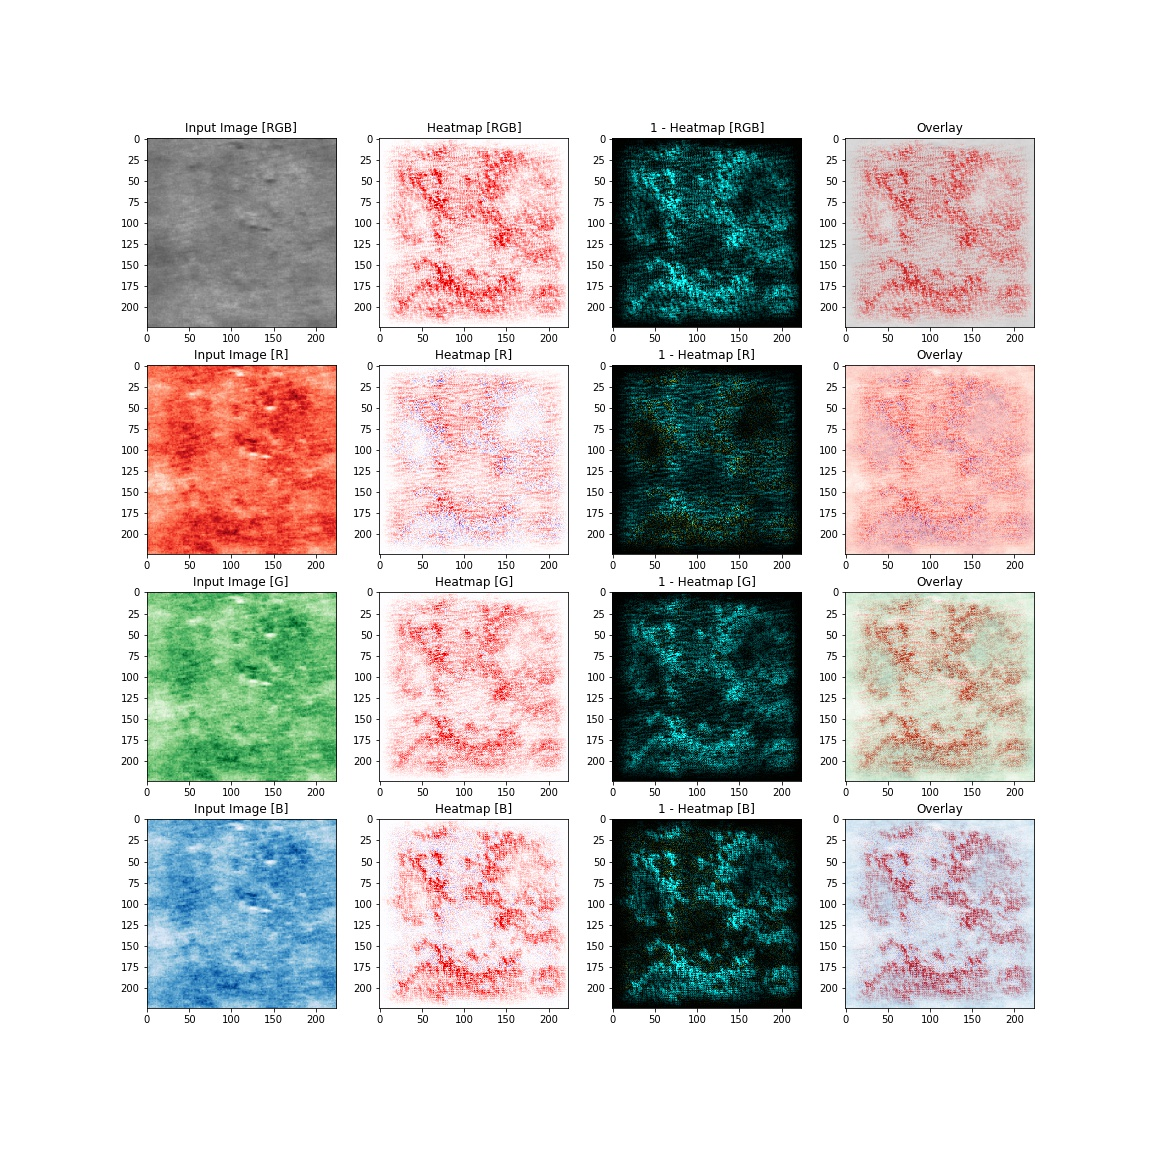

In [8]:
IPImage('/home/jupyter/results/lenet_RS_32_signals_class_0.JPEG')

In [9]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['4', '0']
Top-2 indices(s): [4, 0]
Top-2 logit(s): [7.3577175, 2.1758325]
Top-2 probs(s): [0.99401325, 0.005583779]
----------------------------------------------------------------------
     Signal visualization for class: 4 [4]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_4.pkl
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_0.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_32_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_32_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_RS_32_signals_diff_class_1.JPEG`
class_1 specific invD

##### Example 2

In [10]:
img_path = "NEU-CLS_New/val/Cr/Cr_59.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['0', '3']
Top-2 indices(s): [0, 3]
Top-2 logit(s): [8.163257, 3.32368]
Top-2 probs(s): [0.9846287, 0.007788808]
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_0.pkl
----------------------------------------------------------------------
     Signal visualization for class: 3 [3]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_3.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_Cr_59_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_Cr_59_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_Cr_59_signals_diff_class_1.JPEG`
class_1 specific invDiff 

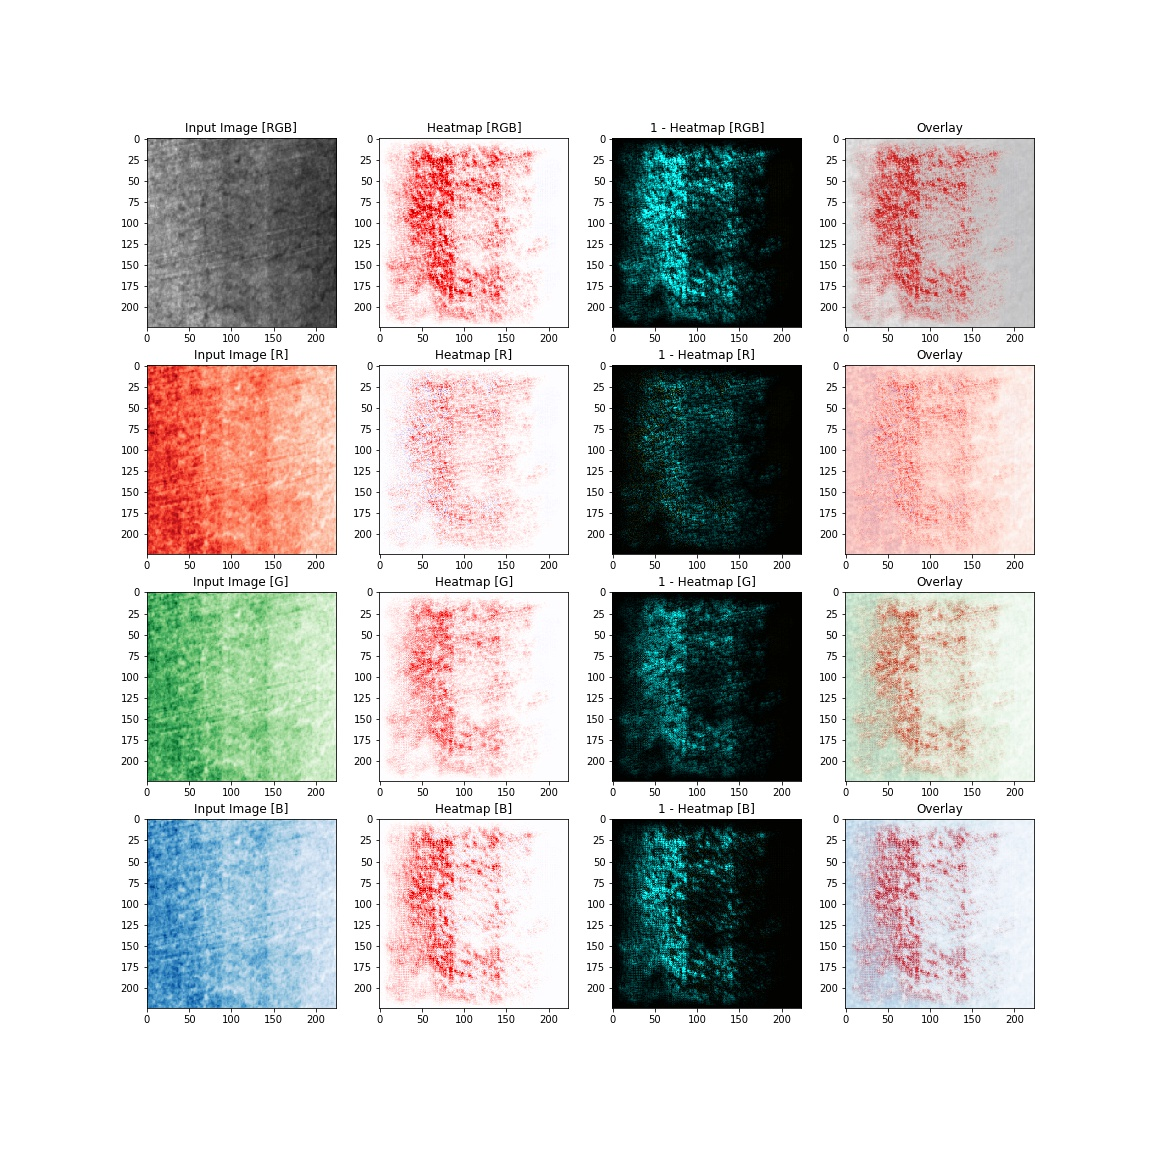

In [11]:
IPImage('/home/jupyter/results/lenet_Cr_59_signals_class_0.JPEG')

In [12]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['0', '3']
Top-2 indices(s): [0, 3]
Top-2 logit(s): [8.163257, 3.32368]
Top-2 probs(s): [0.9846287, 0.007788808]
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_0.pkl
----------------------------------------------------------------------
     Signal visualization for class: 3 [3]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_3.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_Cr_59_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_Cr_59_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_Cr_59_signals_diff_class_1.JPEG`
class_1 specific invDiff 

#### Step 7.2 - Signal Attribution profile | Uncertain Images

##### Example 1

In [13]:
img_path = 'NEU-CLS_New/val/PS/PS_86.bmp'
if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['2', '1']
Top-2 indices(s): [2, 1]
Top-2 logit(s): [8.856834, 7.199834]
Top-2 probs(s): [0.8383757, 0.15988675]
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_2.pkl
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_1.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_PS_86_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_PS_86_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_PS_86_signals_diff_class_1.JPEG`
class_1 specific invDiff 

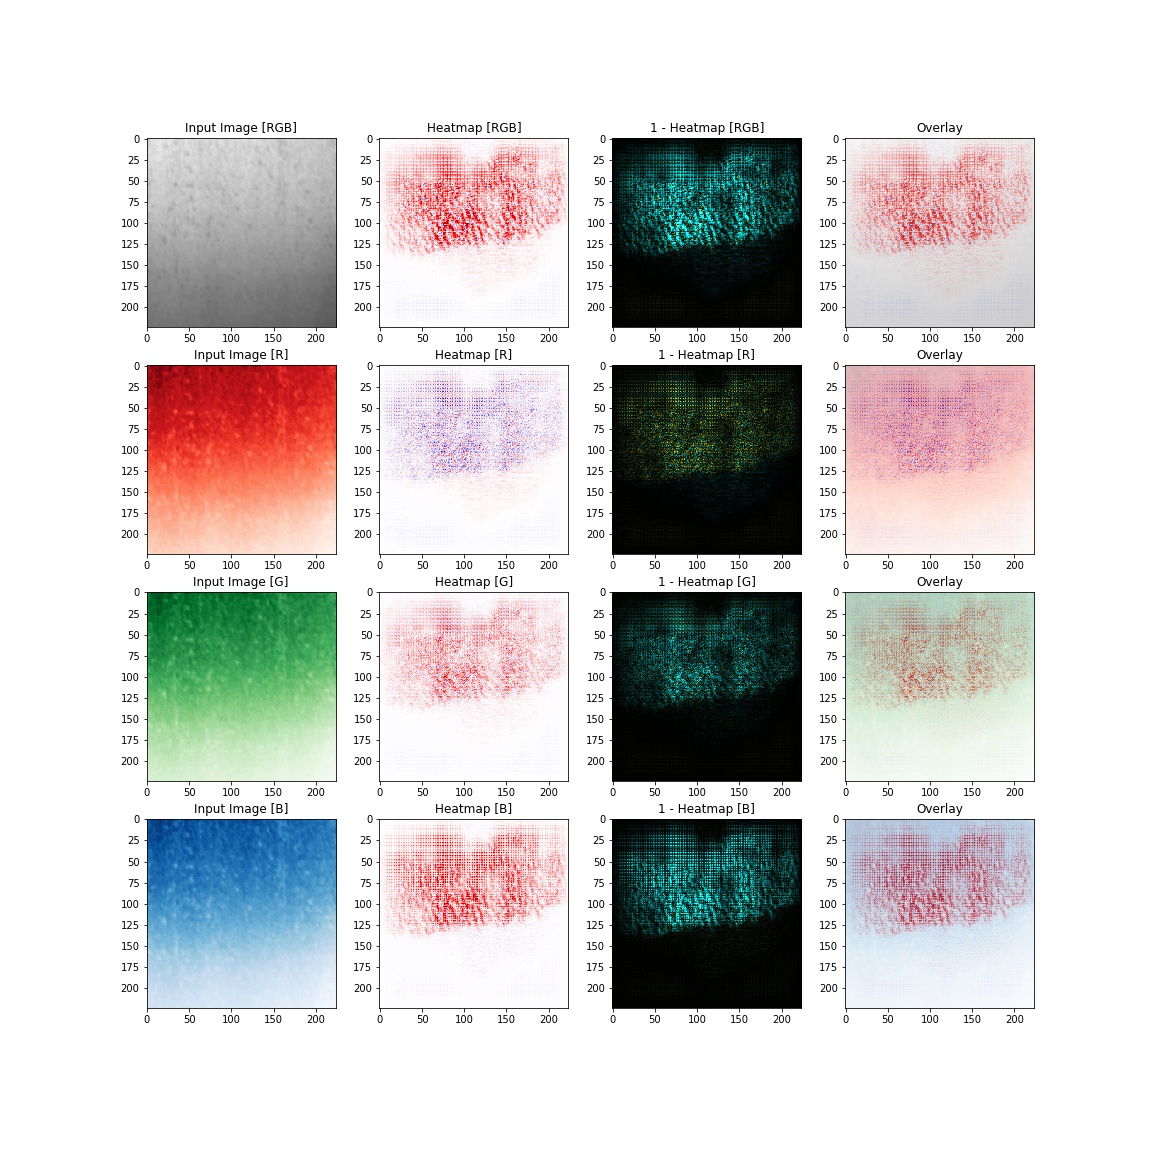

In [14]:
IPImage('/home/jupyter/results/lenet_PS_86_signals_class_0.JPEG')

In [15]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['2', '1']
Top-2 indices(s): [2, 1]
Top-2 logit(s): [8.856834, 7.199834]
Top-2 probs(s): [0.8383757, 0.15988675]
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_2.pkl
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_1.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_PS_86_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_PS_86_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_PS_86_signals_diff_class_1.JPEG`
class_1 specific invDiff 

##### Example 2

In [16]:
img_path = 'NEU-CLS_New/val/Rs/RS_56.bmp'

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['4', '0']
Top-2 indices(s): [4, 0]
Top-2 logit(s): [4.2077937, 1.6257284]
Top-2 probs(s): [0.89035887, 0.06732686]
----------------------------------------------------------------------
     Signal visualization for class: 4 [4]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_4.pkl
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_0.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_56_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_56_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_RS_56_signals_diff_class_1.JPEG`
class_1 specific invDi

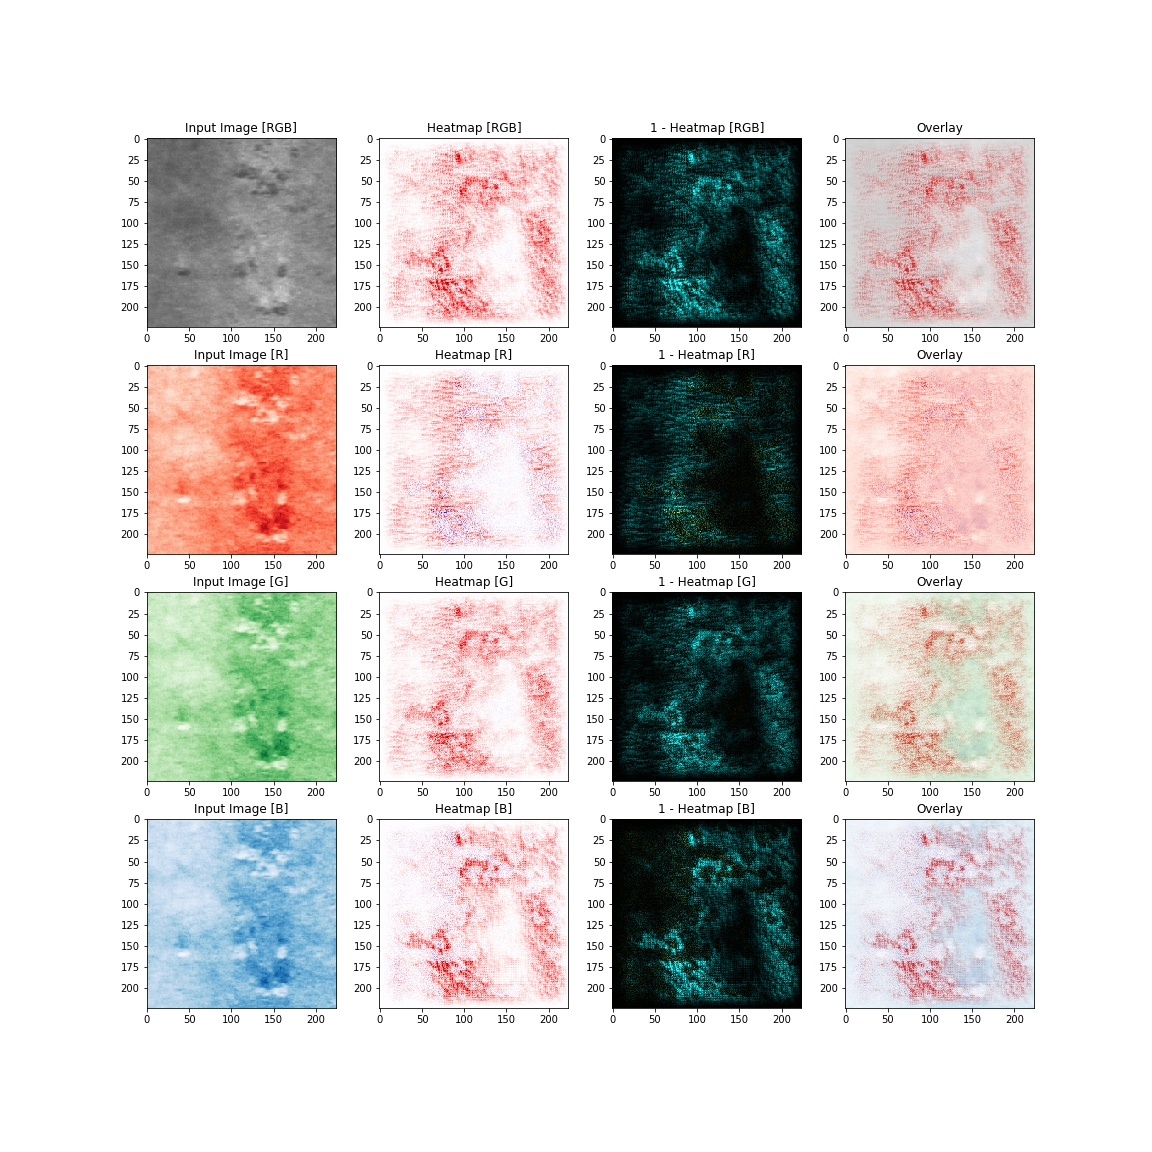

In [17]:
IPImage('/home/jupyter/results/lenet_RS_56_signals_class_0.JPEG')

In [18]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['4', '0']
Top-2 indices(s): [4, 0]
Top-2 logit(s): [4.2077937, 1.6257284]
Top-2 probs(s): [0.89035887, 0.06732686]
----------------------------------------------------------------------
     Signal visualization for class: 4 [4]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_4.pkl
----------------------------------------------------------------------
     Signal visualization for class: 0 [0]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_0.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_56_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_RS_56_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_RS_56_signals_diff_class_1.JPEG`
class_1 specific invDi

#### Step 7.3 - Signal Attribution profile | Miss-classified Images

##### Example 1

In [19]:
img_path = "NEU-CLS_New/val/SC/Sc_39.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['1', '2']
Top-2 indices(s): [1, 2]
Top-2 logit(s): [4.788031, 3.5650613]
Top-2 probs(s): [0.7258269, 0.21365057]
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_1.pkl
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_2.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_39_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_39_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_Sc_39_signals_diff_class_1.JPEG`
class_1 specific invDiff

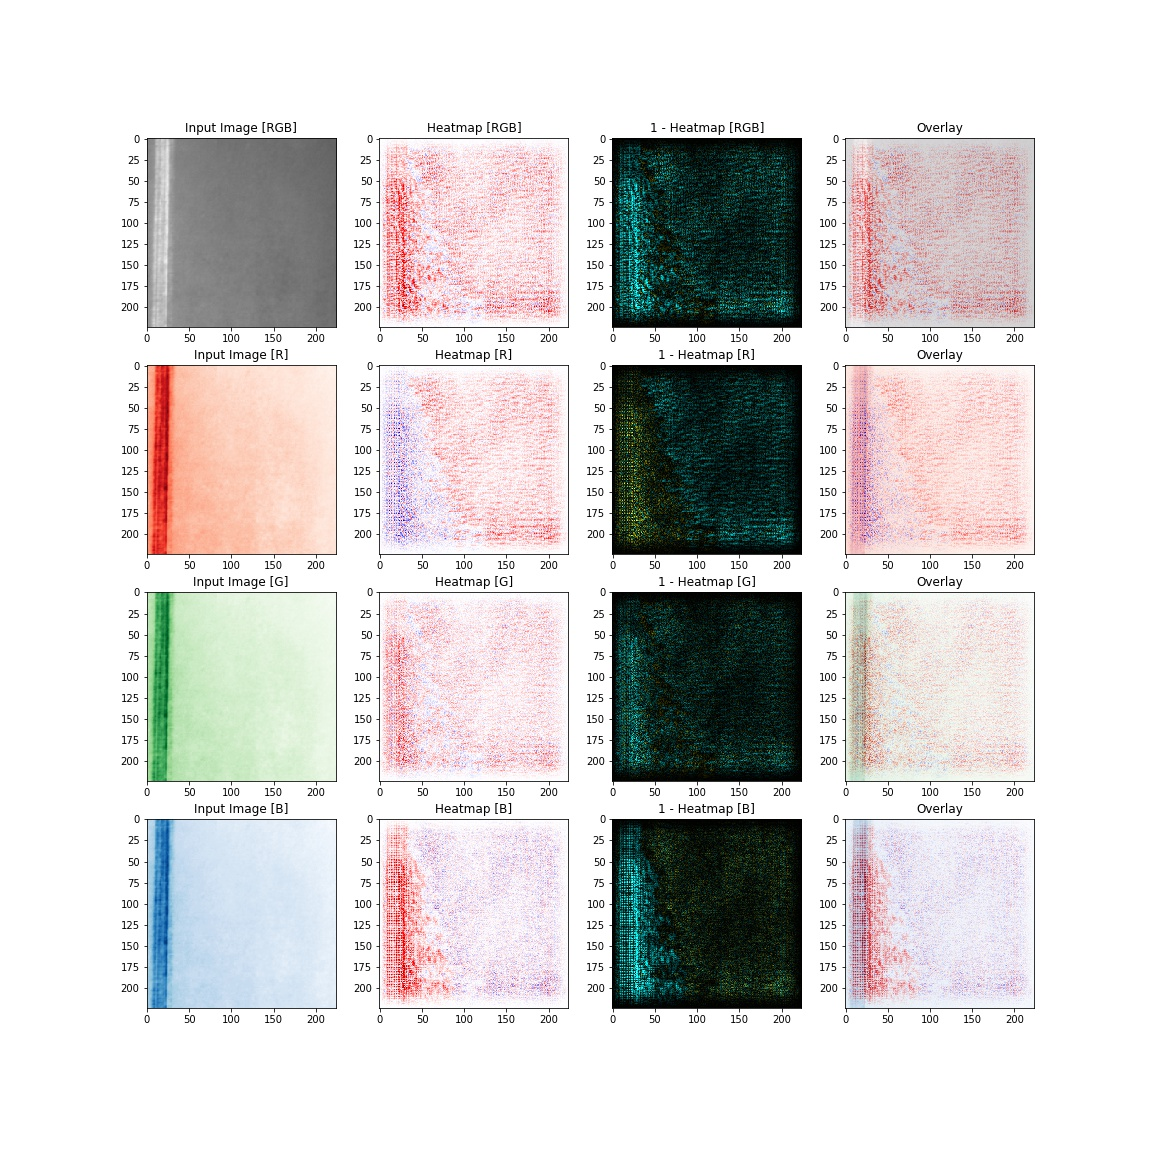

In [20]:
IPImage('/home/jupyter/results/lenet_Sc_39_signals_class_0.JPEG')

In [21]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['1', '2']
Top-2 indices(s): [1, 2]
Top-2 logit(s): [4.788031, 3.5650613]
Top-2 probs(s): [0.7258269, 0.21365057]
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_1.pkl
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_2.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_39_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_39_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_Sc_39_signals_diff_class_1.JPEG`
class_1 specific invDiff

##### Example 2

In [22]:
img_path = "NEU-CLS_New/val/SC/Sc_92.bmp"

if(not os.path.exists(img_path)):
    raise FileNotFoundError(img_path)
inp_image = Image.open(img_path)
inp_image = inp_image.convert("RGB")
crop_inp_image = img_transform(inp_image)
input_tensor = tensor_transform(crop_inp_image)
input_tensor = input_tensor.unsqueeze(0)
if (torch.cuda.is_available()):
    input_tensor = input_tensor.cuda()

img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_{}_signals'.format(args.mname, img_name))
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['2', '1']
Top-2 indices(s): [2, 1]
Top-2 logit(s): [2.542672, 2.316739]
Top-2 probs(s): [0.4271854, 0.34079638]
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_2.pkl
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_1.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_92_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_92_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_Sc_92_signals_diff_class_1.JPEG`
class_1 specific invDiff 

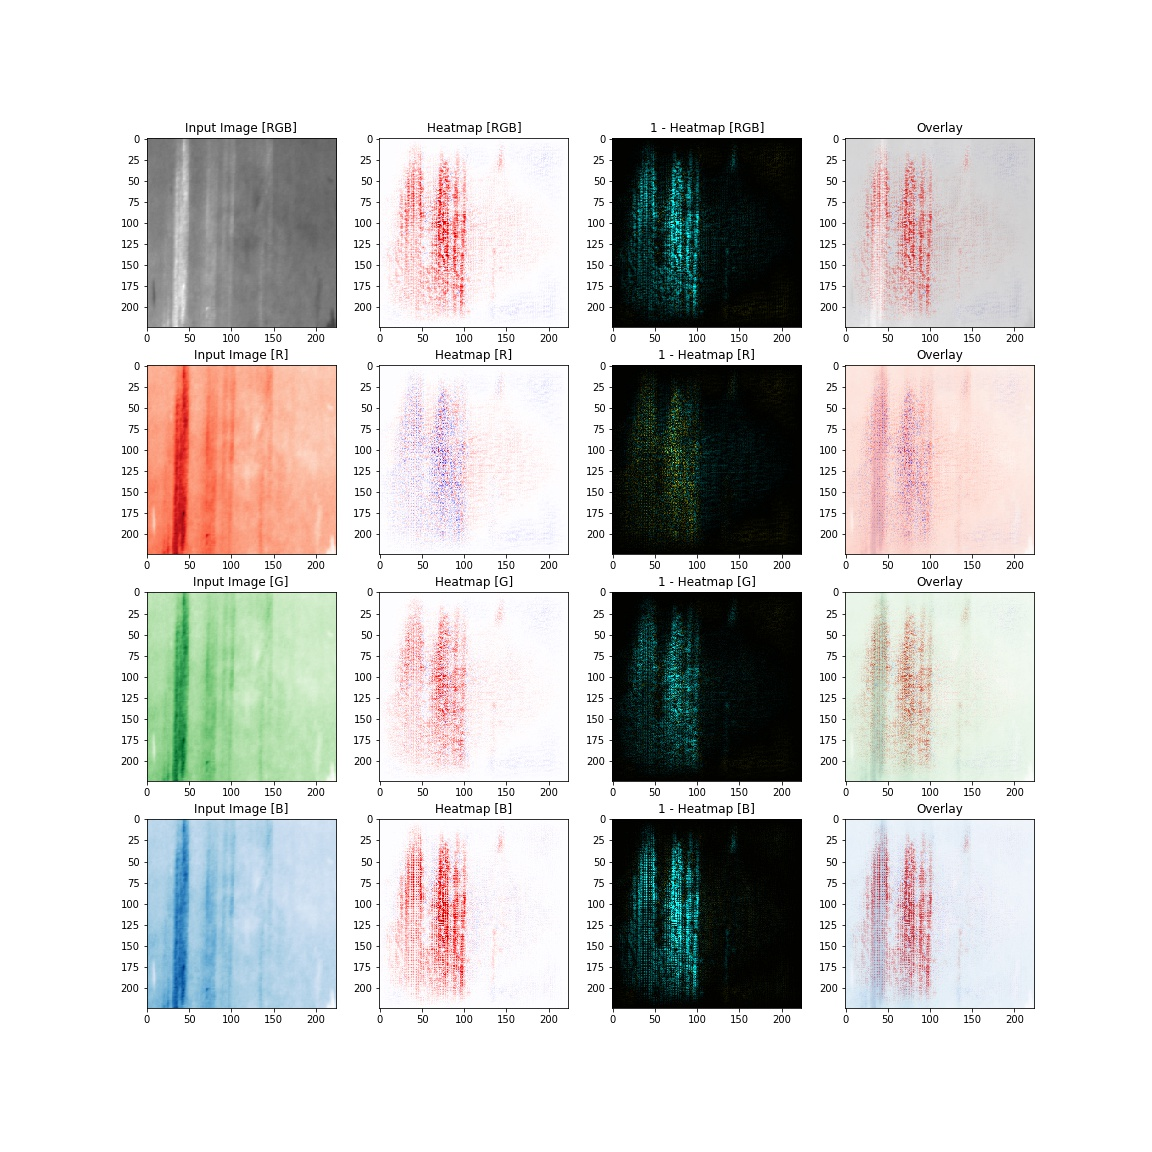

In [23]:
IPImage('/home/jupyter/results/lenet_Sc_92_signals_class_0.JPEG')

In [24]:
%%timeit
gradients = untangle_ai.attribute_signals(model_ft, input_tensor, crop_inp_image, signal_store_path, ID2Name_Map, args, out_prefix)

Top-2 class(es): ['2', '1']
Top-2 indices(s): [2, 1]
Top-2 logit(s): [2.542672, 2.316739]
Top-2 probs(s): [0.4271854, 0.34079638]
----------------------------------------------------------------------
     Signal visualization for class: 2 [2]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_2.pkl
----------------------------------------------------------------------
     Signal visualization for class: 1 [1]
----------------------------------------------------------------------
Using signals: /home/jupyter/model_signal_data/lenet_signal_class_1.pkl
class_0 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_92_signals_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/results/lenet_Sc_92_signals_class_1.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/results/lenet_Sc_92_signals_diff_class_1.JPEG`
class_1 specific invDiff 